In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "decoder" # encoder or decoder
# task = "rte"
task = "cb"
# task = "wic"

## Prompts

In [3]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}.csv")
display(df)

,name,template,category,includes_labels,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False,False
2,gpt_3_true_false_neither,"{premise} Question: {hypothesis} True, False, ...",instructive,True,False
3,gpt_3_yes_no_maybe,"{premise} Question: {hypothesis} Yes, No, or M...",instructive,True,False
4,mnli_crowdsource,{premise} Using only the above description and...,instructive,True,False
5,always_sometimes_never,"Suppose it's true that {premise} Then, is ""{hy...",instructive,True,False
6,based_on_previous_passage,"{premise} Based on the previous passage, is it...",instructive,True,False
7,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,False
8,claim,"{premise} Based on that information, is the cl...",instructive,True,False
9,consider,"{premise} Keeping in mind the above text, cons...",instructive,True,False


## Comput CKA per prompt across layers

In [4]:
# RTE patterns
# use_pattern = [
#     "null_pattern",
#     "null_pattern_reversed",
#     "gpt_3_yes_no",
#     "gpt_3_yes_no_shuffled",
#     "gpt_3_true_false",
#     "gpt_3_true_false_shuffled",
#     "start_with_the",
#     "mnli_crowdsource",
#     "based_on_previous_passage",
#     "infer",
#     "follow",
#     "imply",
#     "guaranteed",
#     "justified", 
#     "must_be_true",
#     "should_assume"
# ]

# CB patterns
use_pattern = [
    "null_pattern",
    "null_pattern_reversed",
    "gpt_3_true_false_neither",
    "gpt_3_yes_no_maybe",
    "mnli_crowdsource",
    "always_sometimes_never",
    "based_on_previous_passage",
    "infer",
    "claim",
    "consider",
    "follow",
    "imply",
    "guaranteed",
    "guaranteed_possible",
    "justified",
    "must_be_true",
    "should_assume",
    "take_the_following",
]

# WIC patterns
# use_pattern = [
#     "gpt_3",
#     "gpt_3_yes_no",
#     "affirmation",
#     "grammar_homework",
#     "polysemous",
#     "question_context",
#     "question_meaning",
#     "question_meaning_yes_no",
#     "same_sense",
#     "similar_sense",
#     "similar_sense_yes_no",
# ]

In [5]:
representations = {}

for _, row in df.iterrows():
    prompt_name = row['name']

    if prompt_name in use_pattern:
        if prompt_name not in representations:
            representations[prompt_name] = {}

    for t in range(2):
        if t not in representations:
            representations[prompt_name][t] = {}
            
            for layer in range(0, 25):
                layer_key = f"{module}-{layer}"

                if layer_key not in representations[prompt_name][t]:
                    representations[prompt_name][t][layer_key] = {}

                file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t{t}_layer{layer}_avg.hdf5"
                
                # load hidden representations from hdf5 file
                representations[prompt_name][t][layer_key] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)

In [6]:
representations.keys()

dict_keys(['null_pattern', 'null_pattern_reversed', 'gpt_3_true_false_neither', 'gpt_3_yes_no_maybe', 'mnli_crowdsource', 'always_sometimes_never', 'based_on_previous_passage', 'infer', 'claim', 'consider', 'follow', 'imply', 'guaranteed', 'guaranteed_possible', 'justified', 'must_be_true', 'should_assume', 'take_the_following'])

In [7]:
representations["null_pattern"].keys()

dict_keys([0, 1])

In [8]:
representations["null_pattern"][0].keys()

dict_keys(['decoder-0', 'decoder-1', 'decoder-2', 'decoder-3', 'decoder-4', 'decoder-5', 'decoder-6', 'decoder-7', 'decoder-8', 'decoder-9', 'decoder-10', 'decoder-11', 'decoder-12', 'decoder-13', 'decoder-14', 'decoder-15', 'decoder-16', 'decoder-17', 'decoder-18', 'decoder-19', 'decoder-20', 'decoder-21', 'decoder-22', 'decoder-23', 'decoder-24'])

In [9]:
representations["null_pattern"][0]["decoder-0"].shape

(56, 2048)

In [10]:
# Compute CKA for every pattern across layers
np_cka = CKA()

cka_scores_pattern = {}
for pattern in list(representations.keys())[:]:
    if pattern not in cka_scores_pattern:
        cka_scores_pattern[pattern] = {}
    for t in range(2):
        cka_scores = []
        for layer1 in representations[pattern][t].keys():
            cka_scores_layer1 = []
            for layer2 in representations[pattern][t].keys():
                cka_score = np_cka.linear_CKA(representations[pattern][t][layer1], representations[pattern][t][layer2])
                cka_scores_layer1.append(cka_score)
            cka_scores.append(cka_scores_layer1)
        cka_scores = np.asarray(cka_scores)
        cka_scores_pattern[pattern][t] = cka_scores

In [11]:
cka_scores_pattern['null_pattern'][0].shape

(25, 25)

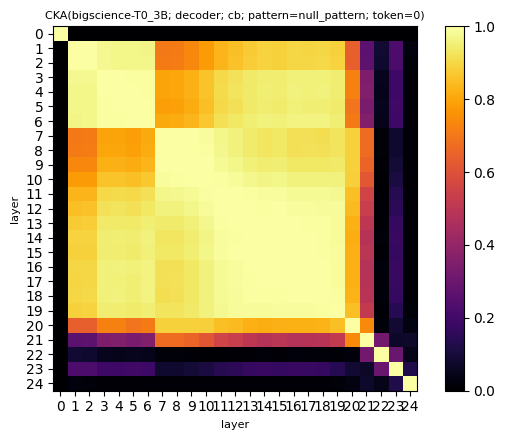

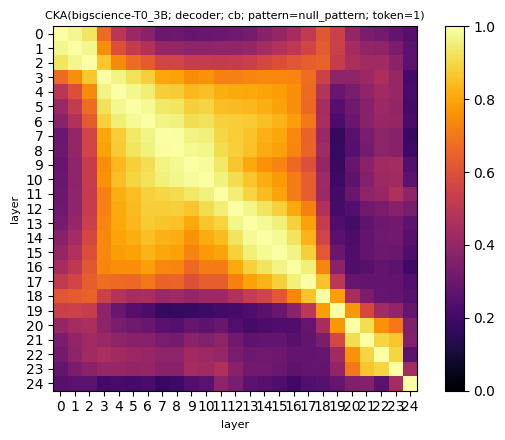

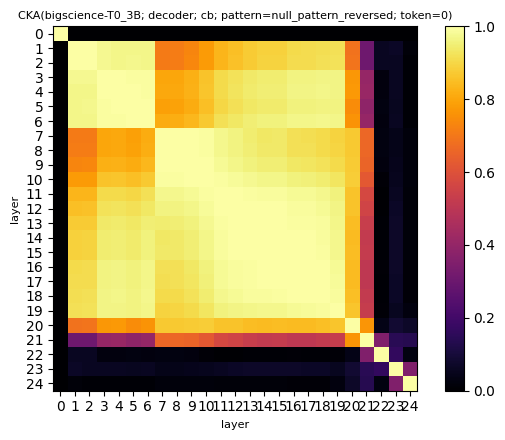

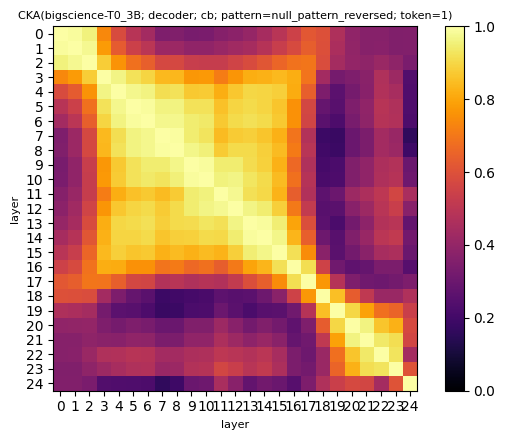

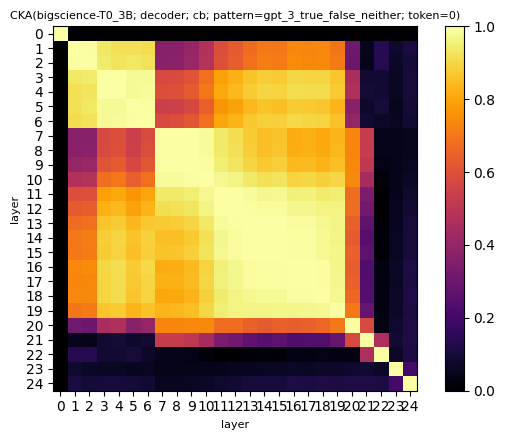

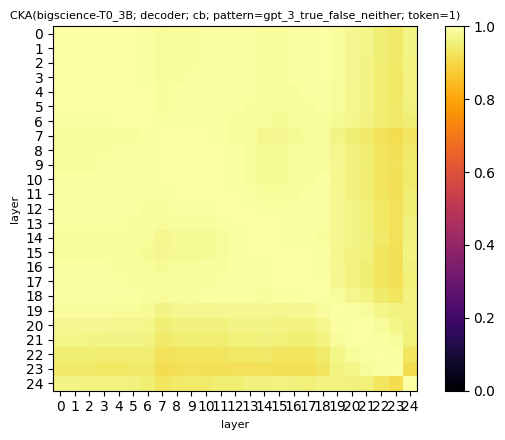

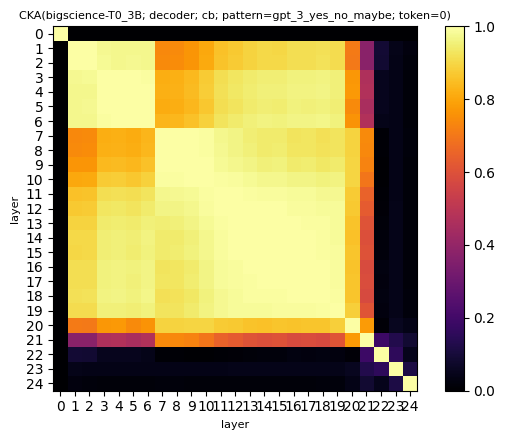

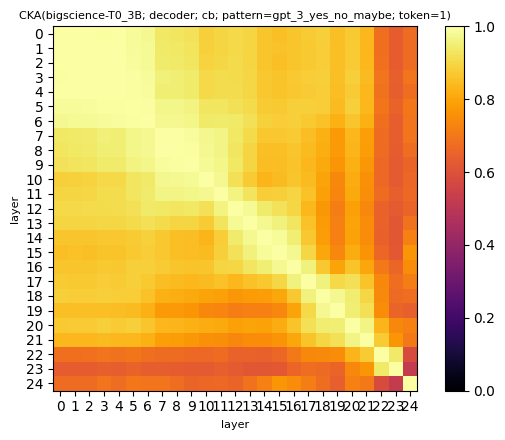

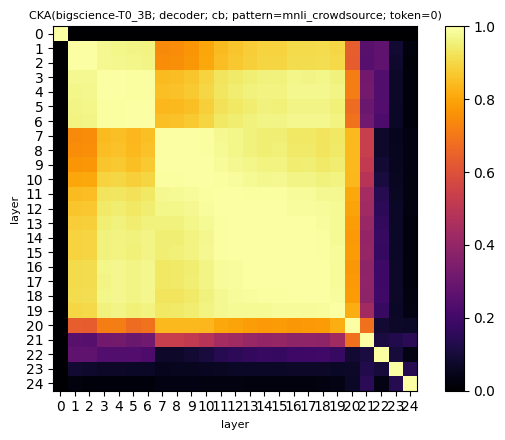

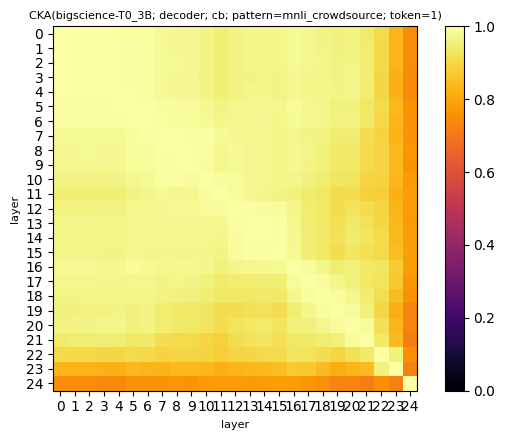

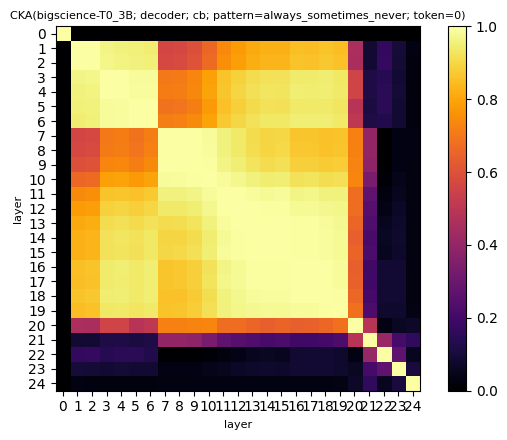

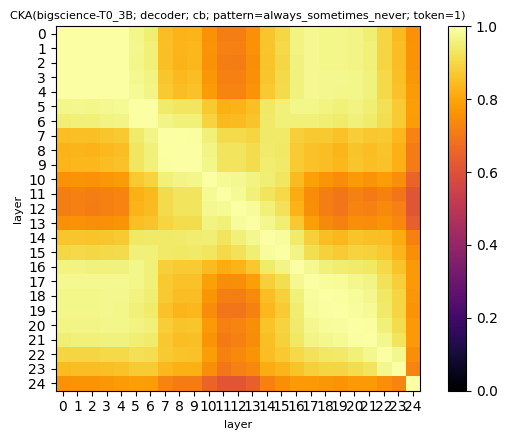

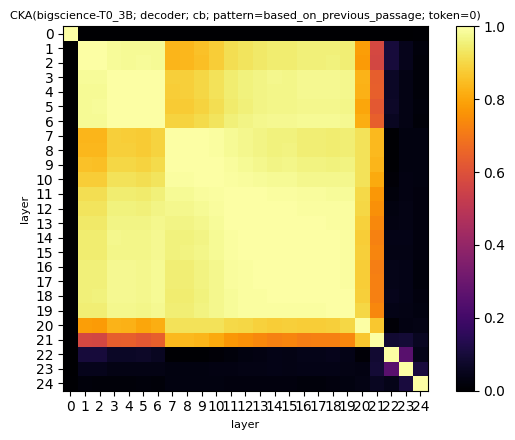

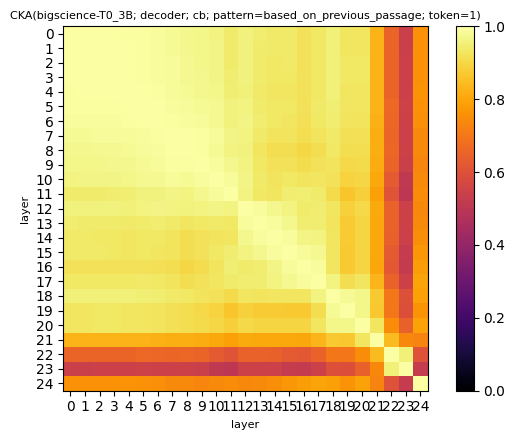

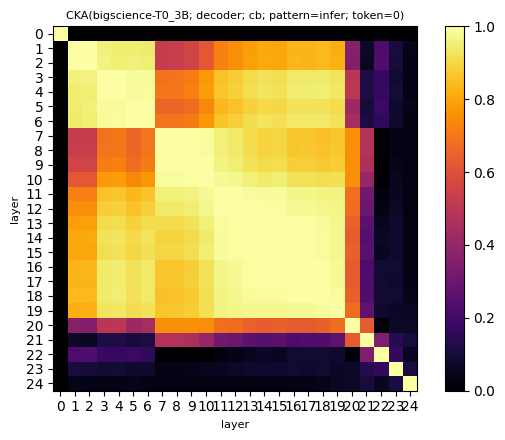

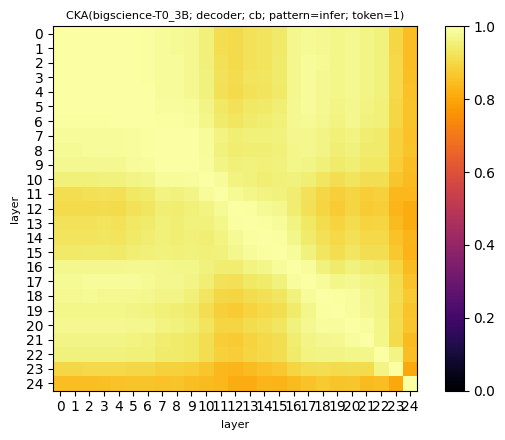

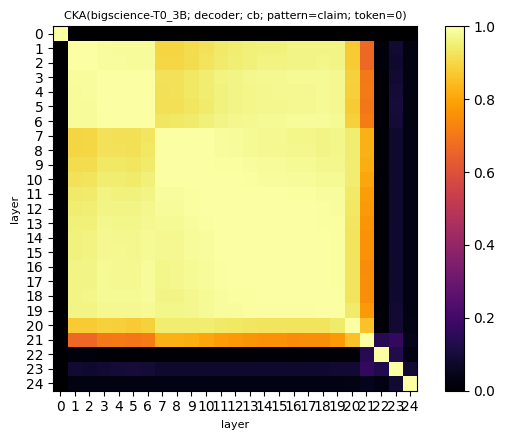

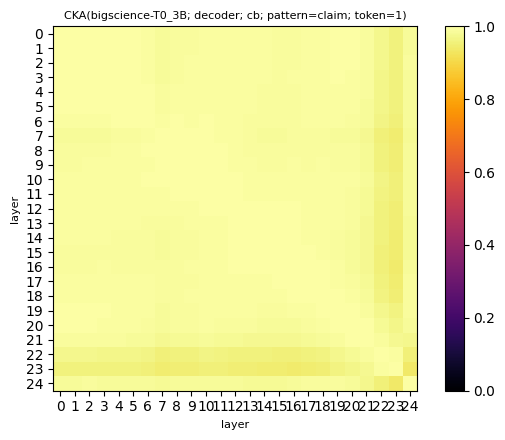

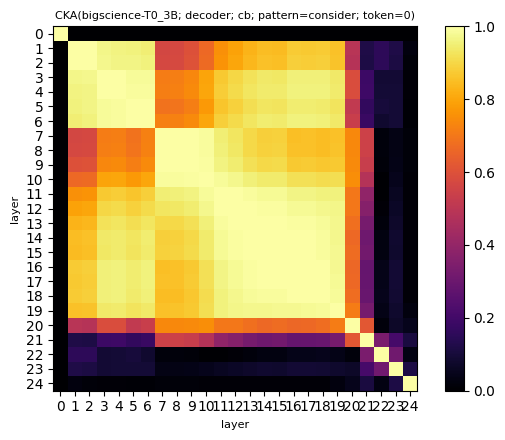

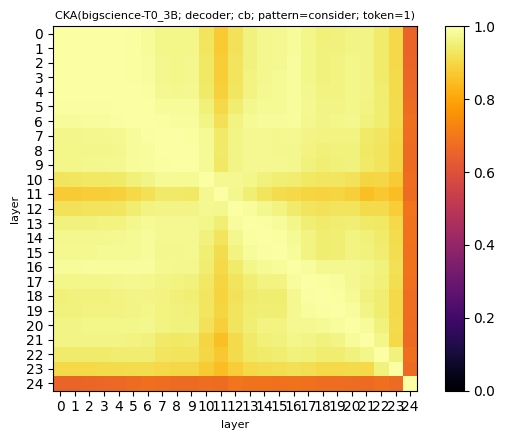

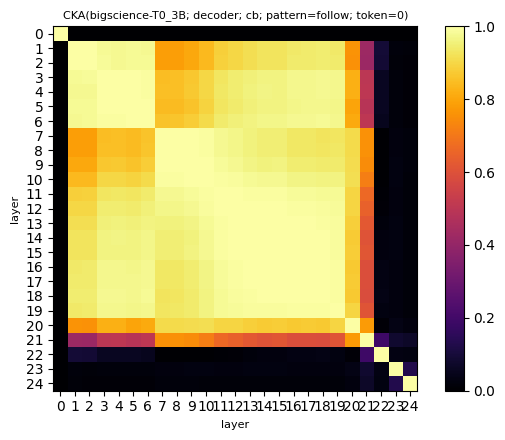

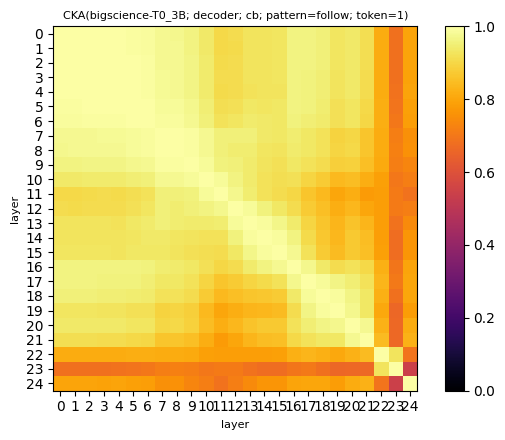

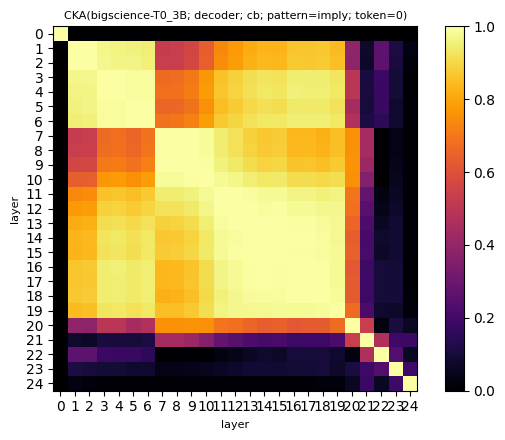

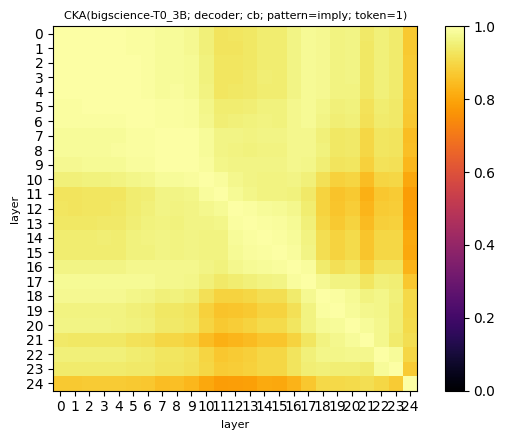

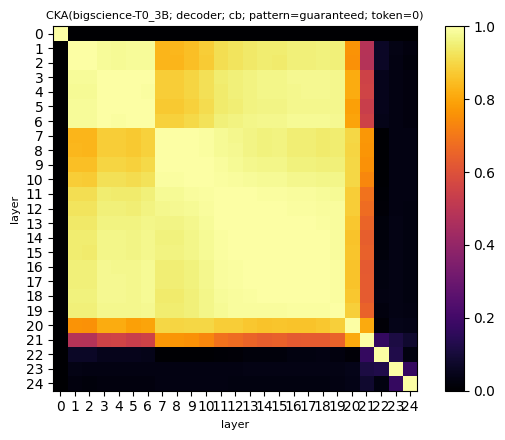

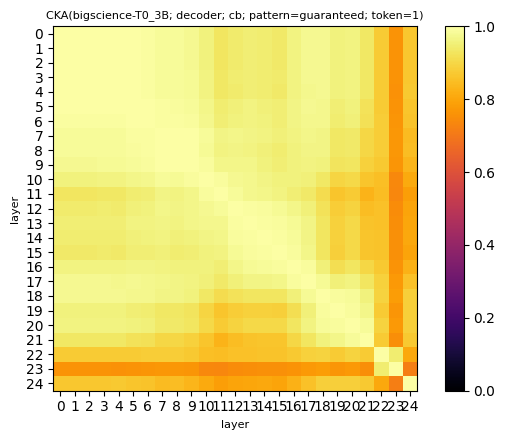

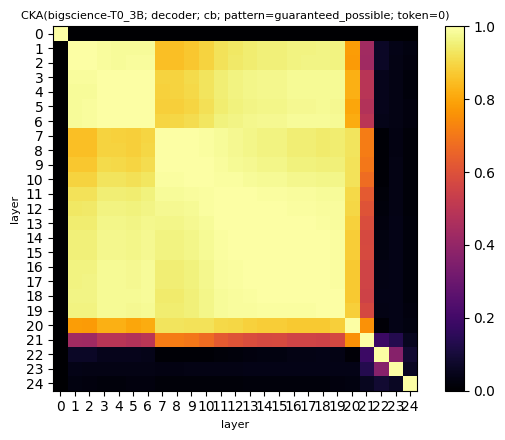

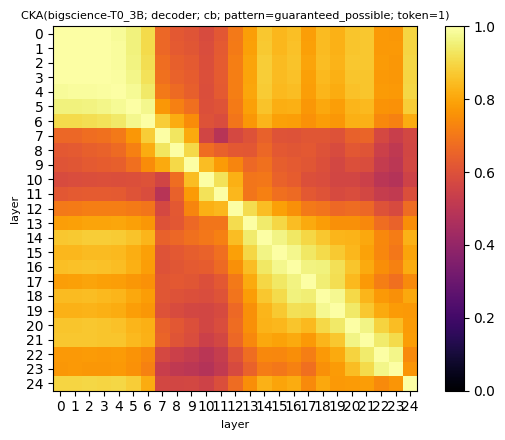

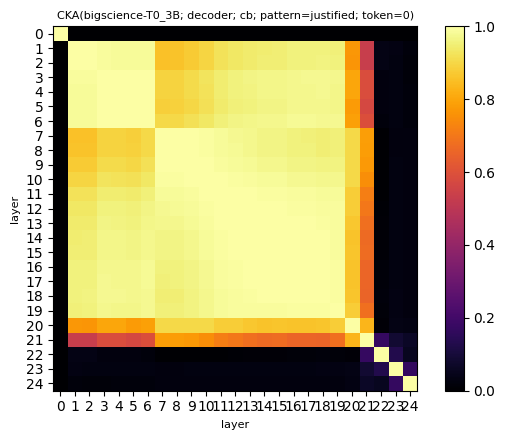

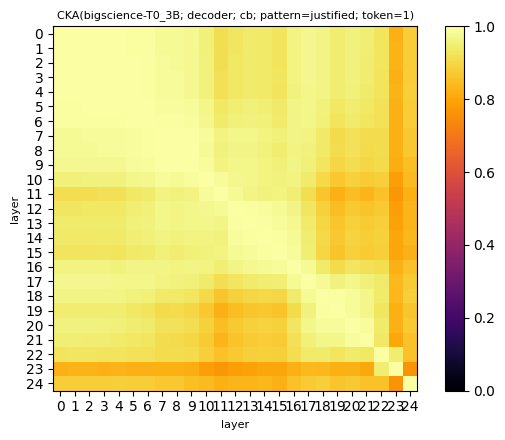

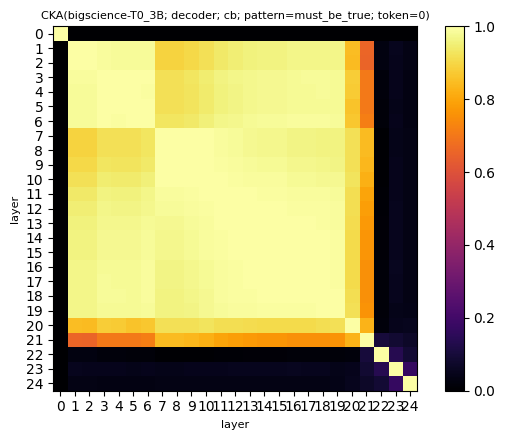

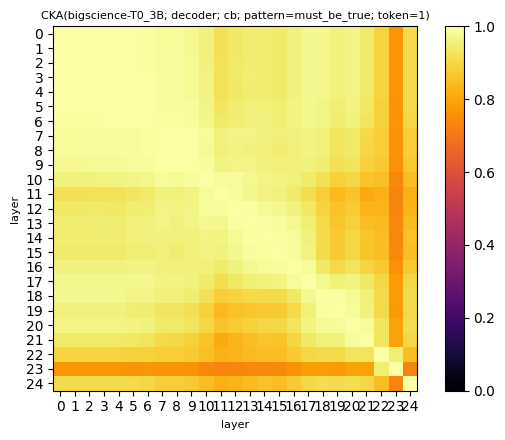

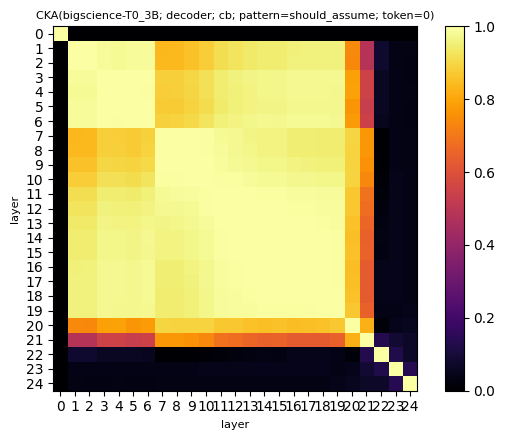

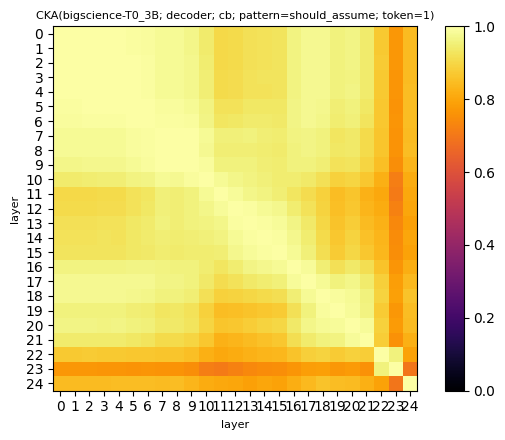

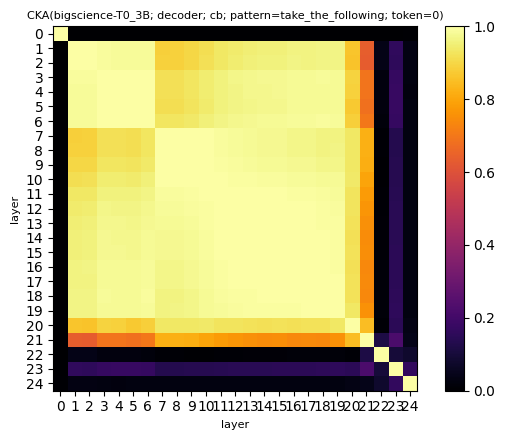

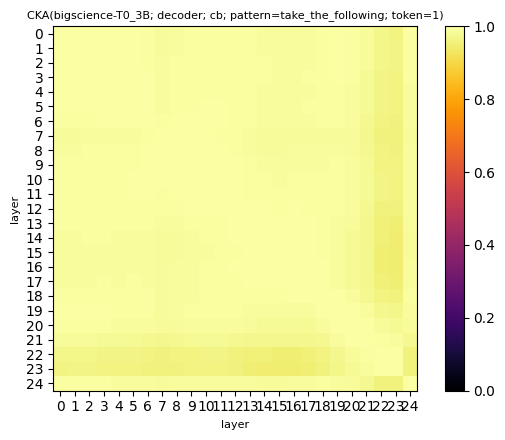

In [13]:
for pattern in list(cka_scores_pattern.keys())[:]:
    for t in range(2):
        values = cka_scores_pattern[pattern][t]

        fig, axes = plt.subplots(1, 1, figsize=(6.0,4.5), dpi=100)

        im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
        # Create colorbar
        cbar = axes.figure.colorbar(im, ax=axes)
        cbar.ax.set_ylabel("", rotation=-90, va="bottom")

        axes.set_xlabel("layer", fontsize=8)
        axes.set_xticks(np.arange(len(values)))
        axes.set_ylabel("layer", fontsize=8)
        axes.set_yticks(np.arange(len(values)))

        axes.set_title(f"CKA({model}; {module}; {task}; pattern={pattern}; token={t})", fontsize=8)

        plt.tight_layout()
        plt.show()
        plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


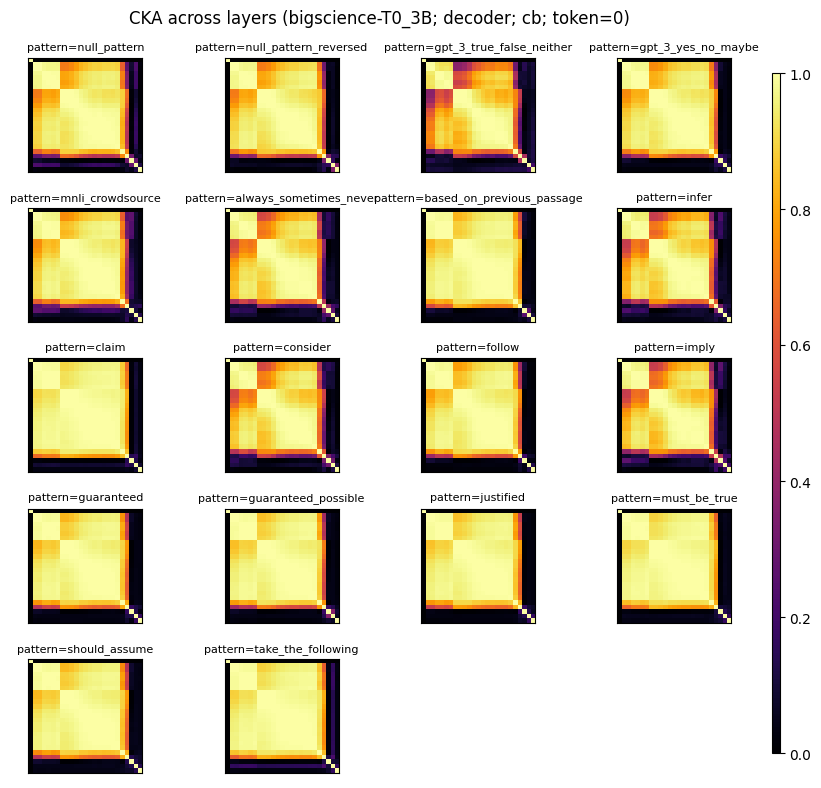

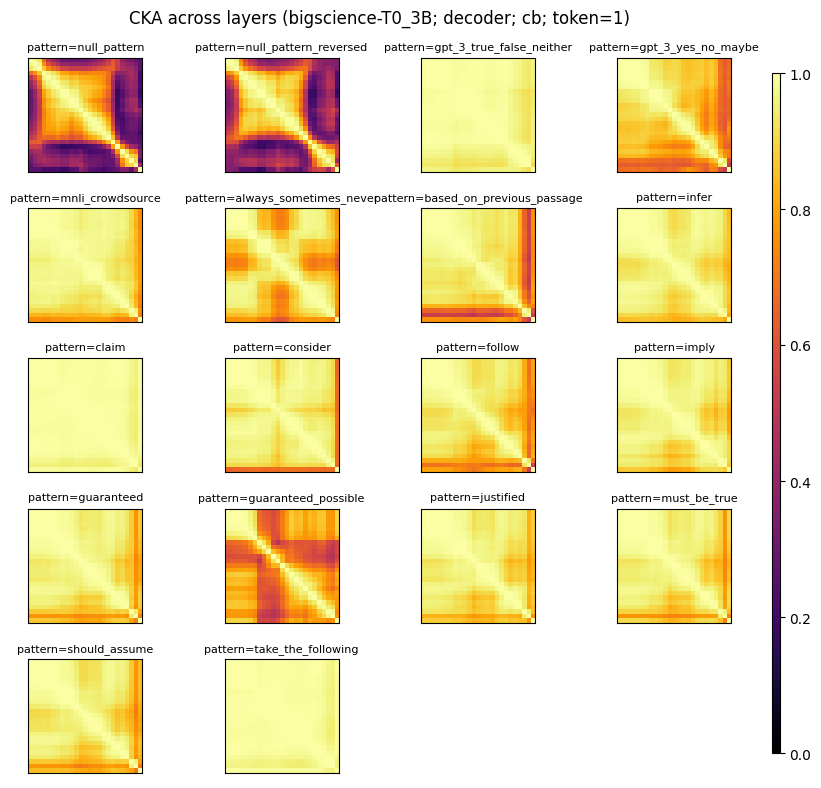

In [14]:
for t in range(2):
    plt.figure(figsize=(8, 8), dpi=100)

    for l, pattern in enumerate(cka_scores_pattern.keys()):
        values = cka_scores_pattern[pattern][t]

        plt.subplot(5, 4, l+1)
        axes = plt.gca()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
        # Create colorbar
        # cbar = axes.figure.colorbar(im, ax=axes)
        # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

        axes.set_xlabel("template", fontsize=8)
        axes.set_xticks(np.arange(len(values)))
        axes.set_ylabel("template", fontsize=8)
        axes.set_yticks(np.arange(len(values)))

        # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
        axes.set_title(f"pattern={pattern}", fontsize=8)

    # add colorbar
    fig = plt.gcf()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.99, 0.05, 0.01, 0.85])
    fig.colorbar(im, cax=cbar_ax)

    plt.suptitle(f"CKA across layers ({model}; {module}; {task}; token={t})")
    plt.tight_layout()
    plt.show()
    plt.close();

In [25]:
df

,name,template,category,includes_labels,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False,False
2,gpt_3_true_false_neither,"{premise} Question: {hypothesis} True, False, ...",instructive,True,False
3,gpt_3_yes_no_maybe,"{premise} Question: {hypothesis} Yes, No, or M...",instructive,True,False
4,mnli_crowdsource,{premise} Using only the above description and...,instructive,True,False
5,always_sometimes_never,"Suppose it's true that {premise} Then, is ""{hy...",instructive,True,False
6,based_on_previous_passage,"{premise} Based on the previous passage, is it...",instructive,True,False
7,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,False
8,claim,"{premise} Based on that information, is the cl...",instructive,True,False
9,consider,"{premise} Keeping in mind the above text, cons...",instructive,True,False
